# Analyzing the results for `lincs_rdkit_hparam`

This is part 2, the results of sweeping the drug-embedding related hyperparameters for all other embeddings

In [1]:
from pathlib import Path
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import seml
from matplotlib import pyplot as plt

matplotlib.style.use("fivethirtyeight")
matplotlib.style.use("seaborn-talk")
matplotlib.rcParams['font.family'] = "monospace"
plt.rcParams['savefig.facecolor'] = 'white'
sns.set_context("poster")
pd.set_option('display.max_columns', 100)

In [2]:
results = seml.get_results(
    "lincs_rdkit_hparam",
    to_data_frame=True,
    fields=["config", "result", "seml", "config_hash"],
    states=["COMPLETED"],
)

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

/home/simon/miniconda3/envs/chemical_CPA/lib/python3.7/site-packages/seml/evaluation.py:80: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  parsed = pd.io.json.json_normalize(parsed, sep='.')


In [3]:
# filter out the non-relevant rdkit runs
results = results[(results["config.model.hparams.dim"] == 32)]
results["config.model.embedding.model"].value_counts()

grover_base    16
weave          16
rdkit           9
MPNN            8
jtvae           7
seq2seq         7
GCN             6
Name: config.model.embedding.model, dtype: int64

In [4]:
results.loc[:, [c for c in results.columns if 'disentanglement' in c]]

,result.perturbation disentanglement,result.covariate disentanglement
0,[0.2929533123970032],[[0.8103122711181641]]
1,[0.24740289151668549],[[0.629379391670227]]
3,[0.2513996362686157],[[0.6995764970779419]]
4,[0.2972831428050995],[[0.9510713219642639]]
8,[0.2822000980377197],[[0.7862206697463989]]
...,...,...
80,[0.28080442547798157],[[0.7576881647109985]]
81,[0.14848296344280243],[[0.528619647026062]]
82,[0.11906234174966812],[[0.36963725090026855]]
83,[0.22075779736042023],[[0.692867636680603]]


In [5]:
good_disentanglement = results['result.perturbation disentanglement'].apply(lambda x: x[0]) < 0.2

In [6]:
results.loc[good_disentanglement, [c for c in results.columns if 'result' in c]]

,result.epoch,result.stats_epoch,result.loss_reconstruction,result.loss_adv_drugs,result.loss_adv_covariates,result.penalty_adv_drugs,result.penalty_adv_covariates,result.elapsed_time_min,result.training,result.test,result.ood,result.perturbation disentanglement,result.optimal for perturbations,result.covariate disentanglement,result.optimal for covariates,result.total_epochs
17,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[525],"[5057.547938257456, 2429.702333241701, 2120.39...","[53271.88210773468, 50945.346554756165, 49536....","[17306.876682281494, 16716.71974515915, 16673....","[5971.463605740023, 382.5912035524735, 169.823...","[6.363920687416794, 0.19839770979615423, 0.101...",784.366952,"[[0.9297907875309965, 0.8460637133426092, 0.02...","[[0.932363020380338, 0.8516415238380433, 0.061...","[[0.9320238392267909, 0.859985808708838, 0.013...",[0.08253635466098785],[0.006978477740242026],[[0.1510840356349945]],[[0.012195121951219513]],525
25,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[150],"[4962.000753134489, 2517.728057682514, 2322.20...","[53235.39468955994, 50731.77633190155, 49426.7...","[17201.264766216278, 16644.660117149353, 16681...","[3554.1937197571024, 12.257525956047544, 17.38...","[6.375064511144956, 0.1077676479708316, 0.1149...",188.328390,"[[0.9092291268830389, 0.7363556157290443, -0.0...","[[0.9033996204535166, 0.755708302060763, -0.10...","[[0.9059013048452991, 0.7745005993970803, -0.1...",[0.12042631953954697],[0.006978477740242026],[[0.5076842308044434]],[[0.012195121951219513]],150
30,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[150],"[4948.855605274439, 2453.1453342735767, 2282.5...","[53288.06770515442, 50887.49008178711, 49477.0...","[17176.229419469833, 16674.85853624344, 16697....","[4205.1418614134745, 8.1179398398765, 623.2925...","[8.475396957003795, 0.1290189927794927, 0.1235...",194.664017,"[[0.9172299045859333, 0.7768192965393568, -0.0...","[[0.9170830324292183, 0.7976464008291563, -0.0...","[[0.9189726885940347, 0.8168569899031094, -0.0...",[0.13408192992210388],[0.006978477740242026],[[0.4625144600868225]],[[0.012195121951219513]],150
31,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[150],"[5007.915769487619, 2496.940879970789, 2284.01...","[53162.24500465393, 50518.11715507507, 49409.5...","[17226.646740198135, 16675.593737840652, 16653...","[3164.3060682879855, 13.428873880301929, 1168....","[8.78075922242897, 0.16737031196362295, 0.0867...",188.264804,"[[0.9085888829856799, 0.7343637996105478, -0.0...","[[0.9104640732208887, 0.7702424615621567, -0.1...","[[0.9137835837900639, 0.792331550270319, -0.14...",[0.16232889890670776],[0.006978477740242026],[[0.5156301856040955]],[[0.012195121951219513]],150
32,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[575],"[5047.344274520874, 2543.3769514262676, 2261.1...","[53226.56231594086, 50754.988428115845, 49454....","[17204.479621887207, 16665.131385326385, 16694...","[3480.4302035069873, 65.98673608250839, 358.62...","[8.46309389793987, 0.11603951289225733, 0.0842...",648.639952,"[[0.9230386534653082, 0.8052882943159524, -0.0...","[[0.9265063469608624, 0.8429866299033165, 0.02...","[[0.9289303555020264, 0.8517431936093739, -0.0...",[0.05283024534583092],[0.006978477740242026],[[0.148847758769989]],[[0.012195121951219513]],575
33,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[150],"[4999.314437150955, 2571.0687064528465, 2341.0...","[53215.257685661316, 50713.547810554504, 49405...","[17131.44260430336, 16688.871186733246, 16683....","[3350.605429873015, 15.601296620186227, 19.492...","[4.9417705957566795, 0.15604488044641585, 0.12...",180.687510,"[[0.8999419144095578, 0.6841317338005107, -0.0...","[[0.8829987674951554, 0.648041479786237, -0.14...","[[0.88655363502247, 0.6636734998651913, -0.200...",[0.13127467036247253],[0.006978477740242026],[[0.4968041479587555]],[[0.012195121951219513]],150
36,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[150],"[4970.603180736303, 2539.268326342106, 2280.05..."

## Preprocessing the results dataframe

In [7]:
sweeped_params = [
    "model.hparams.dim",
    "model.hparams.dropout",
    "model.hparams.dosers_width",
    "model.hparams.dosers_depth",
    "model.hparams.dosers_lr",
    "model.hparams.dosers_wd",
    "model.hparams.autoencoder_width",
    "model.hparams.autoencoder_depth",
    "model.hparams.autoencoder_lr",
    "model.hparams.autoencoder_wd",
    "model.hparams.adversary_width",
    "model.hparams.adversary_depth",
    "model.hparams.adversary_lr",
    "model.hparams.adversary_wd",
    "model.hparams.adversary_steps",
    "model.hparams.reg_adversary",
    "model.hparams.penalty_adversary",
    "model.hparams.batch_size",
    "model.hparams.step_size_lr",
    "model.hparams.embedding_encoder_width",
    "model.hparams.embedding_encoder_depth",
]

In [8]:
# percentage of training runs that resulted in NaNs
import math

nan_results = results[results["result.loss_reconstruction"].apply(lambda x: math.isnan(sum(x)))]
results_clean = results[~results["result.loss_reconstruction"].apply(lambda x: math.isnan(sum(x)))].copy()
print(len(nan_results) / len(results))

0.0


In [9]:
results_clean["config.model.embedding.model"].value_counts()

grover_base    16
weave          16
rdkit           9
MPNN            8
jtvae           7
seq2seq         7
GCN             6
Name: config.model.embedding.model, dtype: int64

In [10]:
# calculate some stats
get_mean = lambda x: np.array(x)[-1, 0]
get_mean_de = lambda x: np.array(x)[-1, 1]

results_clean["result.training_mean"] = results_clean["result.training"].apply(get_mean)
results_clean["result.training_mean_de"] = results_clean["result.training"].apply(get_mean_de)
results_clean["result.val_mean"] = results_clean["result.test"].apply(get_mean)
results_clean["result.val_mean_de"] = results_clean["result.test"].apply(get_mean_de)
results_clean["result.test_mean"] = results_clean["result.ood"].apply(get_mean)
results_clean["result.test_mean_de"] = results_clean["result.ood"].apply(get_mean_de)
results_clean["result.perturbation disentanglement"] = results_clean["result.perturbation disentanglement"].apply(lambda x: x[0])


results_clean

,_id,config_hash,seml.executable,seml.name,seml.output_dir,seml.conda_environment,seml.working_dir,seml.source_files,seml.output_file,seml.command,seml.temp_dir,config.overwrite,config.db_collection,config.dataset.data_params.covariate_keys,config.dataset.data_params.dataset_path,config.dataset.data_params.degs_key,config.dataset.data_params.dose_key,config.dataset.data_params.pert_category,config.dataset.data_params.perturbation_key,config.dataset.data_params.smiles_key,config.dataset.data_params.split_key,config.dataset.data_params.use_drugs_idx,config.dataset.dataset_type,config.model.additional_params.decoder_activation,config.model.additional_params.doser_type,config.model.additional_params.patience,config.model.additional_params.seed,config.model.embedding.directory,config.model.embedding.model,config.model.hparams.adversary_depth,config.model.hparams.adversary_lr,config.model.hparams.adversary_steps,config.model.hparams.adversary_wd,config.model.hparams.adversary_width,config.model.hparams.autoencoder_depth,config.model.hparams.autoencoder_lr,config.model.hparams.autoencoder_wd,config.model.hparams.autoencoder_width,config.model.hparams.batch_size,config.model.hparams.dim,config.model.hparams.dosers_depth,config.model.hparams.dosers_lr,config.model.hparams.dosers_wd,config.model.hparams.dosers_width,config.model.hparams.dropout,config.model.hparams.embedding_encoder_depth,config.model.hparams.embedding_encoder_width,config.model.hparams.penalty_adversary,config.model.hparams.reg_adversary,config.model.hparams.step_size_lr,config.model.load_pretrained,config.model.pretrained_model_hashes,config.model.pretrained_model_path,config.profiling.outdir,config.profiling.run_profiler,config.training.checkpoint_freq,config.training.full_eval_during_train,config.training.max_minutes,config.training.num_epochs,config.training.run_eval_disentangle,config.training.save_checkpoints,config.training.save_dir,config.seed,result.epoch,result.stats_epoch,result.loss_reconstruction,result.loss_adv_drugs,result.loss_adv_covariates,result.penalty_adv_drugs,result.penalty_adv_covariates,result.elapsed_time_min,result.training,result.test,result.ood,result.perturbation disentanglement,result.optimal for perturbations,result.covariate disentanglement,result.optimal for covariates,result.total_epochs,result.training_mean,result.training_mean_de,result.val_mean,result.val_mean_de,result.test_mean,result.test_mean_de
0,1,951c6cef0caf7660d98b49c30a3cb0ca,compert/seml_sweep_icb.py,lincs_rdkit_hparam,/mnt/home/icb/simon.boehm/Masters_thesis/chemi...,chemical_CPA,/mnt/home/icb/simon.boehm/Masters_thesis/chemi...,"[[compert/data.py, 61e6ea51e98f7c50f0d48fcd], ...",/mnt/home/icb/simon.boehm/Masters_thesis/chemi...,python compert/seml_sweep_icb.py with 'profili...,/tmp/2a02983a-dfa5-4b31-aaed-da93cd959885,1,lincs_rdkit_hparam,cell_id,/storage/groups/ml01/projects/2021_chemicalCPA...,rank_genes_groups_cov,pert_dose,cov_drug_dose_name,pert_id,canonical_smiles,random_split,True,lincs,linear,amortized,3,1337,None,rdkit,4,0.000364,2,7.459343e-07,128,3,0.000561,1.329292e-07,512,64,32,2,0.000561,1.329292e-07,128,0.187270,3,512,2.368864,15.355287,100,False,None,None,./,False,25,False,1200,1500,True,True,/storage/groups/ml01/projects/2021_chemicalCPA...,104427122,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[125],"[7668.60909858346, 4221.832088768482, 3187.043...","[106483.20264530182, 99843.51373004913, 98521....","[33686.32508325577, 33318.72813773155, 33357.3...","[2403.7874334401477, 384.58492319871226, 79.95...","[12.919138175999706, 0.18419641748869253, 0.17...",347.128484,"[[0.9075990746769373, 0.7284160405249093, -0.0...","[[0.8994284446040789, 0.7162557100256284, -0.1...","[[0.9028372780552932, 0.7350117628063474, -0.1...",0.292953,[0.006978477740242026],[[0.8103122711181641]],[[0.012195121951219513]],125,0.907599,0.728416,0.899428,0.716256,0.902837,0.735012
1,2,77032057a974ed92ba42eb00b4818b39,compert/seml_sweep_icb.py,lincs_rdkit_hparam,/mnt/home/

## Look at early stopping

Text(0.5, 1.0, 'Total epochs before final stopping (min 125)')

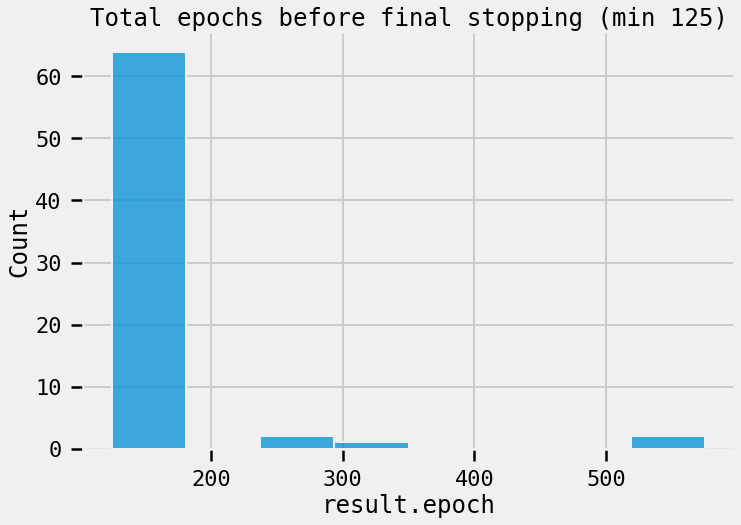

In [11]:
ax = sns.histplot(data=results_clean["result.epoch"].apply(max))
ax.set_title("Total epochs before final stopping (min 125)")

## Look at $r^2$ reconstruction

### DE genes

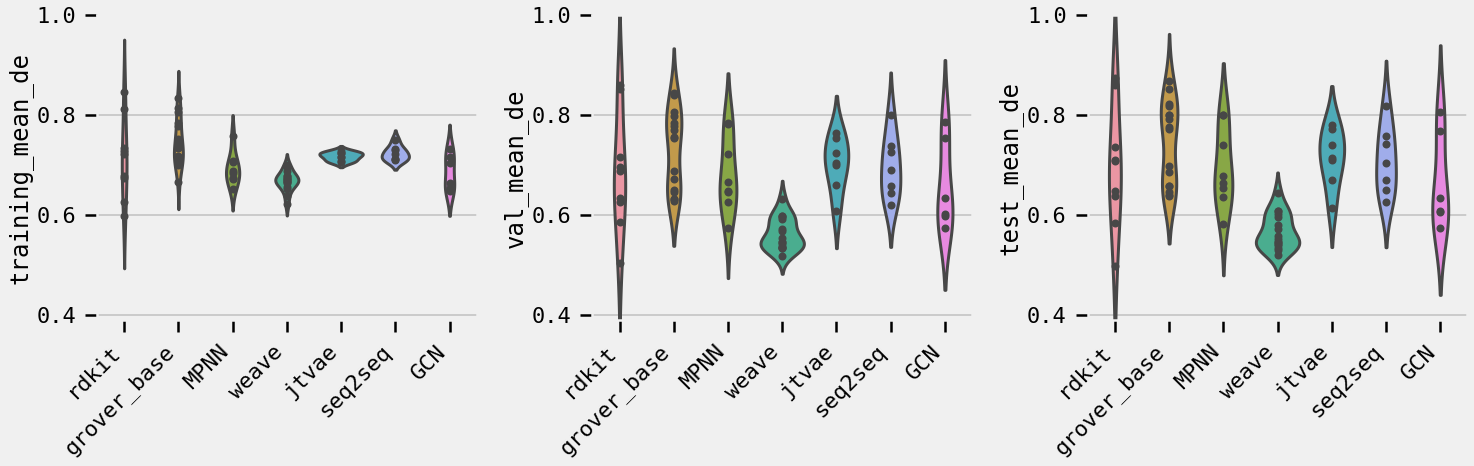

In [12]:
rows = 1 
cols = 3
fig, ax = plt.subplots(rows, cols, figsize=(7*cols, 7*rows), sharex=True)

for i, y in enumerate(("result.training_mean_de", "result.val_mean_de", "result.test_mean_de")):
    sns.violinplot(data=results_clean, x="config.model.embedding.model", y=y, inner='point' ,ax=ax[i])
    ax[i].set_ylim([0.39,1])
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, horizontalalignment="right")
    ax[i].set_xlabel('')
    ax[i].set_ylabel(y.split('.')[-1])
    plt.tight_layout()

### All genes

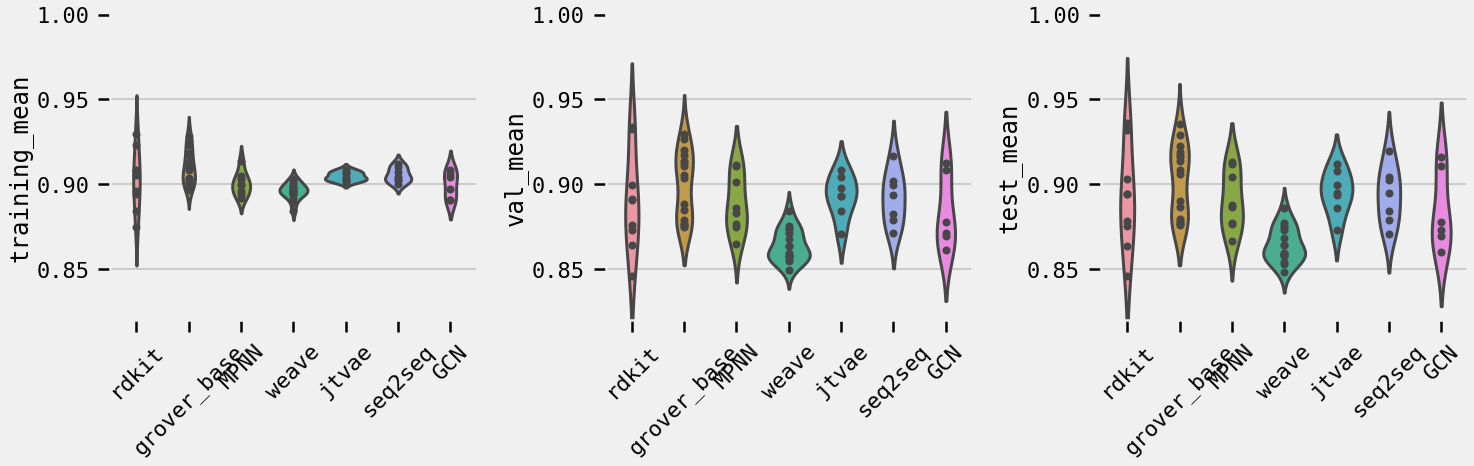

In [13]:
rows = 1 
cols = 3
fig, ax = plt.subplots(rows, cols, figsize=(7*cols, 7*rows), sharex=True)

for i, y in enumerate(("result.training_mean", "result.val_mean", "result.test_mean")):
    sns.violinplot(data=results_clean, x="config.model.embedding.model", y=y, inner='point' ,ax=ax[i])
    ax[i].set_ylim([0.82,1])
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45)
    ax[i].set_xlabel('')
    ax[i].set_ylabel(y.split('.')[-1])
    plt.tight_layout()

## Look at disentanglement scores

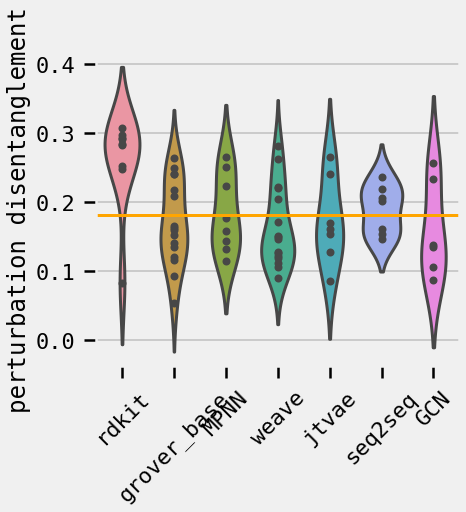

In [14]:
rows = 1 
cols = 1
fig, ax = plt.subplots(rows, cols, figsize=(7*cols, 7*rows), sharex=True)

for y in ["result.perturbation disentanglement"]:
    sns.violinplot(data=results_clean, x="config.model.embedding.model", y=y, inner='point' ,ax=ax)
    # ax[i].set_ylim([0,1])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.axhline(0.18, color='orange')
    ax.set_xlabel('')
    ax.set_ylabel(y.split('.')[-1])
    plt.tight_layout()

## Subselect to disentangled models

In [15]:


performance_condition = lambda emb, max_entangle: (results_clean["config.model.embedding.model"] == emb) & (results_clean["result.perturbation disentanglement"] < max_entangle)

best = []
for embedding in list(results_clean["config.model.embedding.model"].unique()):
    df = results_clean[performance_condition(embedding, 0.18)]
    print(embedding, len(df))
    best.append(df.sort_values(by="result.val_mean_de", ascending=False).head(3))

best = pd.concat(best)

rdkit 1
grover_base 10
MPNN 5
weave 11
jtvae 5
seq2seq 3
GCN 4


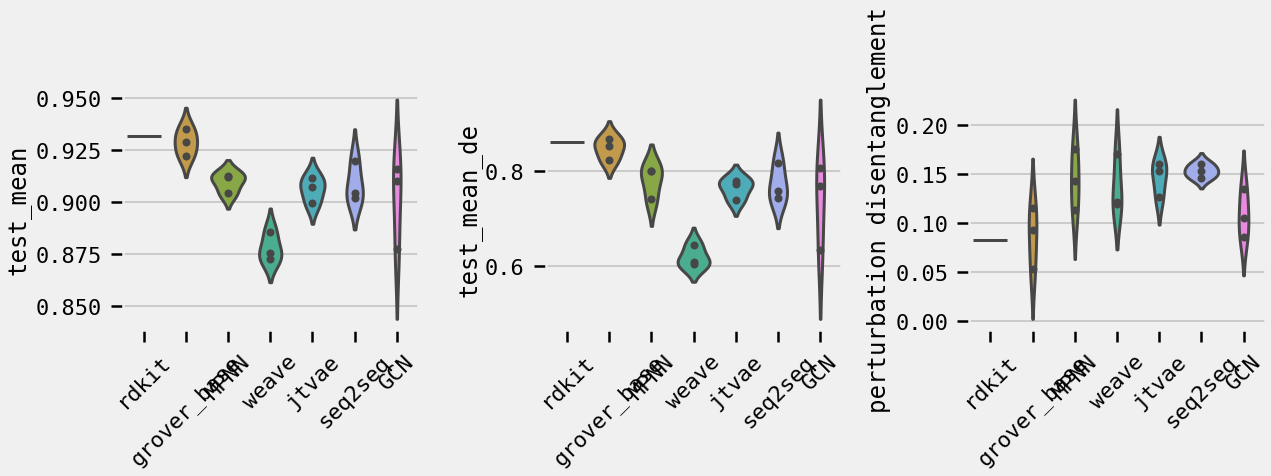

In [16]:
# All genes, DE genes, disentanglement
rows, cols = 1, 3
fig, ax = plt.subplots(rows, cols, figsize=(6*cols,6*rows))

for i, y in enumerate(["result.test_mean", "result.test_mean_de", "result.perturbation disentanglement"]):
    sns.violinplot(data=best, x="config.model.embedding.model", y=y, inner='points', ax=ax[i])
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45)
    ax[i].set_xlabel('')
    ax[i].set_ylabel(y.split('.')[-1])

plt.tight_layout()


## Take a deeper look in the `.config` of the best performing models

In [17]:
best[["config." + col for col in sweeped_params] +
     ["result.perturbation disentanglement", "result.test_mean", "result.test_mean_de"]]

,config.model.hparams.dim,config.model.hparams.dropout,config.model.hparams.dosers_width,config.model.hparams.dosers_depth,config.model.hparams.dosers_lr,config.model.hparams.dosers_wd,config.model.hparams.autoencoder_width,config.model.hparams.autoencoder_depth,config.model.hparams.autoencoder_lr,config.model.hparams.autoencoder_wd,config.model.hparams.adversary_width,config.model.hparams.adversary_depth,config.model.hparams.adversary_lr,config.model.hparams.adversary_wd,config.model.hparams.adversary_steps,config.model.hparams.reg_adversary,config.model.hparams.penalty_adversary,config.model.hparams.batch_size,config.model.hparams.step_size_lr,config.model.hparams.embedding_encoder_width,config.model.hparams.embedding_encoder_depth,result.perturbation disentanglement,result.test_mean,result.test_mean_de
17,32,0.262378,64,3,0.001121,3.752056e-07,256,4,0.001121,3.752056e-07,128,3,0.000806,0.000004,2,24.082073,3.347776,128,50,128,4,0.082536,0.932024,0.859986
32,32,0.262378,512,1,0.005399,3.967605e-06,256,4,0.001121,3.752056e-07,128,3,0.000806,0.000004,2,24.082073,3.347776,128,50,128,2,0.052830,0.928930,0.851743
70,32,0.262378,512,2,0.002607,1.331122e-06,256,4,0.001121,3.752056e-07,128,3,0.000806,0.000004,2,24.082073,3.347776,128,50,128,3,0.115018,0.935222,0.867343
68,32,0.262378,256,3,0.005399,3.967605e-06,256,4,0.001121,3.752056e-07,128,3,0.000806,0.000004,2,24.082073,3.347776,128,50,256,4,0.092941,0.922398,0.821897
40,32,0.262378,512,1,0.005399,3.967605e-06,256,4,0.001121,3.752056e-07,128,3,0.000806,0.000004,2,24.082073,3.347776,128,50,128,2,0.113353,0.912871,0.799676
38,32,0.262378,64,2,0.000205,2.937538e-08,256,4,0.001121,3.752056e-07,128,3,0.000806,0.000004,2,24.082073,3.347776,128,50,256,4,0.175715,0.912020,0.799269
39,32,0.262378,512,1,0.000131,1.493657e-08,256,4,0.001121,3.752056e-07,128,3,0.000806,0.000004,2,24.082073,3.347776,128,100,256,3,0.142504,0.904415,0.739414
82,32,0.262378,256,3,0.005399,3.967605e-06,256,4,0.001121,3.752056e-07,128,3,0.000806,0.000004,2,24.082073,3.347776,128,50,256,4,0.119062,0.885921,0.643844
78,32,0.262378,128,3,0.002911,1.570297e-06,256,4,0.001121,3.752056e-07,128,3,0.000806,0.000004,2,24.082073,3.347776,128,100,512,4,0.169974,0.875566,0.607293
79,32,0.262378,64,2,0.001575,6.251374e-07,256,4,0.001121,3.752056e-07,128,3,0.000806,0.000004,2,24.082073,3.347776,128,50,128,4,0.121663,0.872746,0.602517


In [18]:
# -> Middle sized autoencoder width
results_clean['config.model.hparams.autoencoder_width'].value_counts()

256    62
128     4
512     3
Name: config.model.hparams.autoencoder_width, dtype: int64

In [19]:
# -> rather high regularisation
results_clean['config.model.hparams.reg_adversary'].sort_values(ascending=False)[:10]

1     86.273583
8     30.271829
3     30.049874
50    24.082073
60    24.082073
66    24.082073
65    24.082073
64    24.082073
63    24.082073
62    24.082073
Name: config.model.hparams.reg_adversary, dtype: float64